In [1]:
# Pip install command below is used for updating the code stored on conda env
#!pip install -e git+https://github.com/casperbroch/ai-economist@stockmarket#egg=ai-economist

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

In [3]:
# Define the configuration of the environment that will be built

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'stock_market_simulation',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Execute Circuit Breaker (planner action)
        #('ExecCircuitBreaker', {}),
        # (2) Buy Or Sell Stocks (agent action)
        ('BuyOrSellStocks', {}),
    ],
    
    'static': False,
    'liq_importance': 0.58,
    'stock_price_history_length': 101,
    'stock_quantity': 200,
    
    'base_volume': 30,
    'base_std': 25,
    

    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [1, 1], # [Height, Width] of the env world
    'episode_length': 100, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': False,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    'dense_log_frequency': 1
}

num_days = 101

In [4]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\caspe\AppData\Roaming\Python\Python37\site-

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (21,)
time           : (1,)
world-Endogenous-AvailableFunds: (1,)
world-Endogenous-Demand: (1,)
world-Endogenous-StockPrice: (1,)
world-Endogenous-StockPriceHigh: (1,)
world-Endogenous-StockPriceLow: (1,)
world-Endogenous-StockPricePrevious: (1,)
world-Endogenous-Supply: (1,)
world-Endogenous-TotalBalance: (1,)


[EnvWrapper] Obs (p)   
action_mask    : (1,)
time           : (1,)
world-liquidity: (1,)
world-stability: (1,)


[EnvWrapper] Action (a) Discrete(21)
[EnvWrapper] Action (p) Discrete(1)


In [5]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

In [6]:
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

In [7]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

In [8]:
trainer_config.update(
    {
        "num_workers": 2,
        "num_envs_per_worker": 2,
        "train_batch_size":  4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1,
        "lr": 0.005,
    }
)

In [9]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

In [10]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2024-06-18 12:53:45,821	INFO resource_spec.py:212 -- Starting Ray with 4.54 GiB memory available for workers and up to 2.28 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2024-06-18 12:53:48,310	INFO services.py:1165 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '192.168.1.41',
 'raylet_ip_address': '192.168.1.41',
 'redis_address': '192.168.1.41:6379',
 'object_store_address': 'tcp://127.0.0.1:57066',
 'raylet_socket_name': 'tcp://127.0.0.1:64612',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\caspe\\AppData\\Local\\Temp\\ray\\session_2024-06-18_12-53-45_785829_18056'}

In [11]:
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    )

2024-06-18 12:53:53,422	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2024-06-18 12:53:53,425	INFO trainer.py:585 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2024-06-18 12:53:53,426	INFO trainer.py:612 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=17988) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=17988)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=17988) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=17988)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=17988) C:\Users\caspe\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=17988)   _np_qint16 = np.dtype([("qint

(pid=1864) Inside covid19_components.py: 0 GPUs are available.
(pid=1864) No GPUs found! Running the simulation on a CPU.
(pid=1864) Inside covid19_env.py: 0 GPUs are available.
(pid=1864) No GPUs found! Running the simulation on a CPU.
(pid=17988) Inside covid19_components.py: 0 GPUs are available.
(pid=17988) No GPUs found! Running the simulation on a CPU.
(pid=17988) Inside covid19_env.py: 0 GPUs are available.
(pid=17988) No GPUs found! Running the simulation on a CPU.


In [12]:
# Function created for policy and dense logging
def generate_rollout_with_policy_logging(trainer, env_obj, num_dense_logs=1):
    dense_logs = {}
    policy_logs = []  # This will store the policy logs

    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                action = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )
                actions[str(agent_idx)] = action
                
                # Log the state and action#
                policy_logs.append({
                    'agent_id': str(agent_idx),
                    'state': obs[str(agent_idx)],
                    'action': action
                })
                
            # Action sampling for the planner
            planner_action =  trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )
            actions["p"] = planner_action

            # Log the planner's state and action
            policy_logs.append({
                'agent_id': 'p',
                'state': obs['p'],
                'action': planner_action
            })

            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
                
        dense_logs[idx] = env_obj.env.dense_log

    return dense_logs, policy_logs

def compute_average_balance(dense_logs):
    total_balance_sum = 0.0
    num_logs = len(dense_logs)

    for idx in range(num_logs):
        states = dense_logs[idx]['states']
        agent_balance_sum = sum(log["0"]["endogenous"]["TotalBalance"] for log in states)
        total_balance_sum += agent_balance_sum
    
    if num_logs > 0:
        avg_balance = total_balance_sum / (num_logs * len(states))  # Average across all logs and agents
    else:
        avg_balance = 0.0
    
    return avg_balance


In [13]:
# ! Training loop !
NUM_ITERS = 80
start_train = time.time()

max_rew = 0

avg_balance_history = []
rew_history = []

for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    start = time.time()
    
    # Generate dense logs and policy logs
    dense_logs, _ = generate_rollout_with_policy_logging(trainer, env_obj, num_dense_logs=10)
    
    # Compute average total balance from dense logs
    avg_balance = compute_average_balance(dense_logs)
    avg_balance_history.append(avg_balance)
    
    # Train the trainer
    result = trainer.train()
    length = time.time() - start
    ep_rew = result.get('episode_reward_mean')
    
    rew_history.append(ep_rew)
    
    # Check and save best trainer based on episode reward mean
    if ep_rew > max_rew:
        max_rew = ep_rew
        checkpoint_path = trainer.save()
        print(f'new best trainer found, saving...')
    
    # Logging
    print(f'episode_reward_mean: {ep_rew}')
    print(f'average_total_balance: {avg_balance}')
    print(f'it_time_taken: {length}')

length_train = time.time() - start_train
print("Training took", length_train, " seconds.")

********** Iter : 0 **********
new best trainer found, saving...
episode_reward_mean: 91.47080475719234
average_total_balance: 16356.503640867128
it_time_taken: 49.160184144973755
********** Iter : 1 **********
new best trainer found, saving...
episode_reward_mean: 91.51283610043038
average_total_balance: 17442.15922795253
it_time_taken: 53.77805829048157
********** Iter : 2 **********
episode_reward_mean: 90.44099892313432
average_total_balance: 16364.472451790722
it_time_taken: 51.889453411102295
********** Iter : 3 **********
episode_reward_mean: 91.28135753076027
average_total_balance: 17691.243659162425
it_time_taken: 33.28585767745972
********** Iter : 4 **********
new best trainer found, saving...
episode_reward_mean: 92.4163646307352
average_total_balance: 18709.14915207063
it_time_taken: 31.646315574645996
********** Iter : 5 **********
new best trainer found, saving...
episode_reward_mean: 93.11163302121466
average_total_balance: 17725.25027370526
it_time_taken: 31.8600597381

new best trainer found, saving...
episode_reward_mean: 97.74470214265081
average_total_balance: 19168.52449520221
it_time_taken: 31.90554165840149
********** Iter : 54 **********
episode_reward_mean: 97.62224779076138
average_total_balance: 18471.823893290453
it_time_taken: 31.490671634674072
********** Iter : 55 **********
new best trainer found, saving...
episode_reward_mean: 97.77149117479499
average_total_balance: 18710.238743028356
it_time_taken: 31.744608640670776
********** Iter : 56 **********
episode_reward_mean: 97.76565784269569
average_total_balance: 19759.878357679958
it_time_taken: 30.686537504196167
********** Iter : 57 **********
new best trainer found, saving...
episode_reward_mean: 98.43190100713049
average_total_balance: 18918.700754729405
it_time_taken: 30.93906283378601
********** Iter : 58 **********
new best trainer found, saving...
episode_reward_mean: 98.85939068248297
average_total_balance: 19229.56154704266
it_time_taken: 33.872299909591675
********** Iter : 

In [14]:
# Generate rollouts and get policy logs
trainer.restore(checkpoint_path)
dense_logs, policy_logs = generate_rollout_with_policy_logging(trainer, env_obj, num_dense_logs=1)

2024-06-18 13:37:42,294	INFO trainable.py:423 -- Restored on 192.168.1.41 from checkpoint: C:\Users\caspe/ray_results\PPO_RLlibEnvWrapper_2024-06-18_12-53-53_bojrrc1\checkpoint_71\checkpoint-71
2024-06-18 13:37:42,294	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 71, '_timesteps_total': None, '_time_total': 1432.6466562747955, '_episodes_total': 2840}


In [15]:
ranges = np.arange(0, num_days, 2.0)

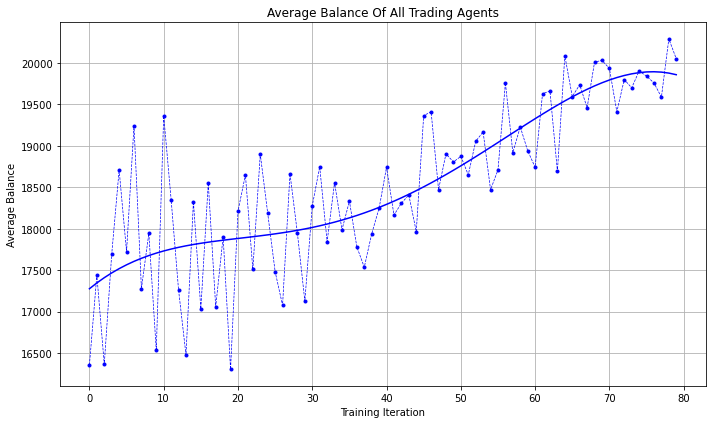

In [18]:
iterations = range(len(avg_balance_history))
    
# Compute the trend line (n-degree polynomial)
n = 4
fit = np.polyfit(iterations, avg_balance_history, n)
p = np.poly1d(fit)
    
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, avg_balance_history, marker='.', linestyle='--', color='b', label='Average Balance', linewidth=0.7)
plt.plot(iterations, p(iterations), color='b', label='Quartic Trend Line') 
plt.title('Average Balance Of All Trading Agents')
plt.xlabel('Training Iteration')
plt.ylabel('Average Balance')
plt.grid(True)
plt.tight_layout()
plt.savefig('averagebalance')
plt.show()

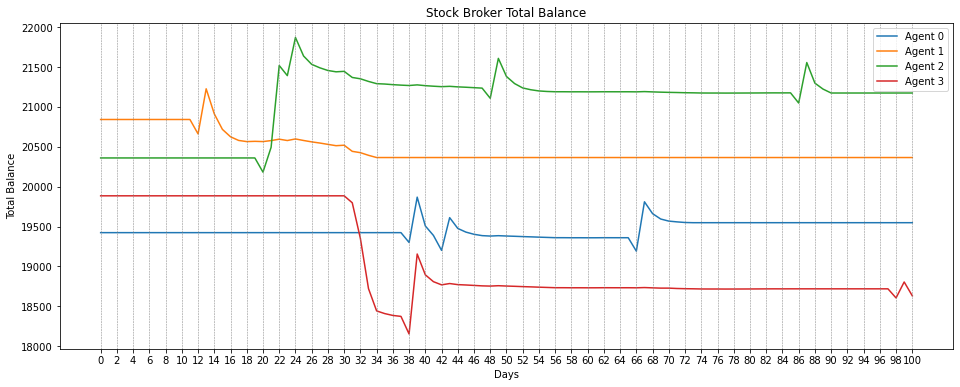

In [19]:
# Plot stock broker balance over a single simulation
agent_0_total_balance = [log["0"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_1_total_balance = [log["1"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_2_total_balance = [log["2"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]
agent_3_total_balance = [log["3"]["endogenous"]["TotalBalance"] for log in dense_logs[0]['states']]

plt.figure(figsize=(16, 6))
plt.plot(np.arange(0,num_days),agent_0_total_balance, label="Agent 0")
plt.plot(np.arange(0,num_days),agent_1_total_balance, label="Agent 1")
plt.plot(np.arange(0,num_days),agent_2_total_balance, label="Agent 2")
plt.plot(np.arange(0,num_days),agent_3_total_balance, label="Agent 3")
plt.title('Stock Broker Total Balance')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Total Balance')
plt.xticks(ranges)

# Adding vertical lines at each xtick position
for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)
    
#plt.savefig("miners_green_scores.png")
plt.show()

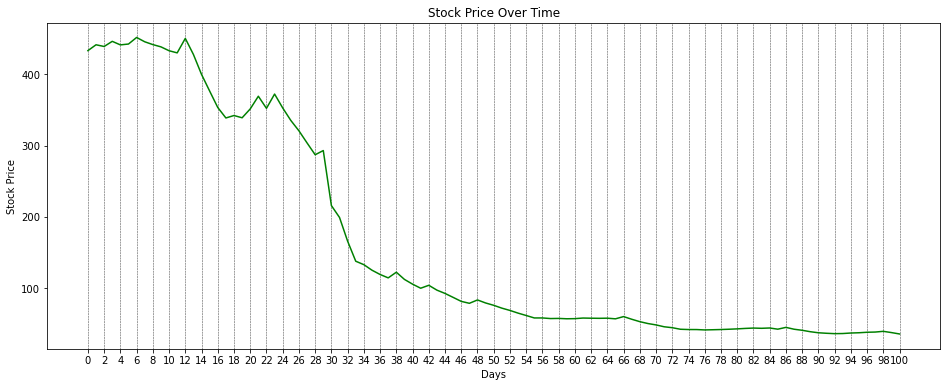

In [20]:
able_to_trade_1 = np.array([log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']])
stock_prices_1 = np.array([log["0"]["endogenous"]["StockPriceHistory"] for log in dense_logs[0]['states']][-1])
able_to_trade_1 = np.delete(able_to_trade_1, 0)

plt.figure(figsize=(16, 6))
plt.title('Stock Price Over Time')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.xticks(ranges)

# Adding vertical lines at each xtick position
for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)

for xtick in ranges:
    plt.axvline(x=xtick, color='gray', linestyle='--', linewidth=0.5)



intervals = []
current_color = able_to_trade_1[0]
start = 0
for i in range(len(able_to_trade_1)):
    if able_to_trade_1[i] != current_color:
        intervals.append((start, i, current_color))
        start = i
        current_color = able_to_trade_1[i]
intervals.append((start, len(able_to_trade_1), current_color))

# Plotting
for idx, (start, end, color) in enumerate(intervals):
    end += 1
    if color == 1:
        plt.plot(range(start, end), stock_prices_1[start:end], color='green')
    else:
        plt.plot(range(start, end), stock_prices_1[start:end], color='red')

plt.show()

In [21]:
# Code below is used to get a summary of a single simulation at each time step (day) !
def planner_reward_total(timestep, volumes, prices, liq_importance=0.5):
    liq = planner_reward_liq(timestep, volumes, 10)
    stab = planner_reward_stab(timestep, prices, 2)
    print("liq score ",liq)
    print("stab score ",stab)
    
    reward = (liq_importance * liq) - ((1-liq_importance) * stab)
    return reward

def planner_reward_liq(timestep, volumes, window_size):
    max_volume = max(volumes[:timestep+1])
    base_volume = 30
    
    if max_volume < base_volume:
        max_volume = base_volume
        
    l = 2
    if timestep<l+1:
        curr_volumes = volumes[0:timestep+1]
    else:
        curr_volumes = volumes[timestep-l+1:timestep+1]
    print(curr_volumes)
    curr_volume = sum(curr_volumes) / len(curr_volumes)
    return curr_volume / max_volume
    

def planner_reward_stab(timestep, prices, window_size):
    if timestep < window_size - 1:
        return 0.0
    
    rolling_stds = [np.std(prices[i:i+window_size]) for i in range(timestep - window_size + 2)]
    current_std = rolling_stds[-1]
        
    max_std = max(rolling_stds)
    base_std = 20
    
    if max_std < base_std:
        max_std = base_std
    
    normalized_std = current_std / max_std if max_std != 0 else 0  # Avoid division by zero
    
    return normalized_std

volumes = [log["0"]["endogenous"]["Volumes"] for log in dense_logs[0]['states']]
stopped = [log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']]
prices = [log["0"]["endogenous"]["StockPriceHistory"] for log in dense_logs[0]['states']]

agent_0_demand = [log["0"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_1_demand = [log["1"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_2_demand = [log["2"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]
agent_3_demand = [log["3"]["endogenous"]["Demand"] for log in dense_logs[0]['states']]

agent_0_supply = [log["0"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_1_supply = [log["1"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_2_supply = [log["2"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]
agent_3_supply = [log["3"]["endogenous"]["Supply"] for log in dense_logs[0]['states']]

agents_demands = [x + y + z + f for x, y, z, f in zip(agent_0_demand, agent_1_demand,agent_2_demand, agent_3_demand )]
agents_supplies = [x + y + z + f for x, y, z, f in zip(agent_0_supply, agent_1_supply,agent_2_supply, agent_3_supply )]

prices[100]

i=0
while i < num_days:
    print("--- Summary of Day", i, "---")
    if i == num_days-1:
        print("Last price: ", prices[-1][i])
        break
    print("Price: ", prices[-1][i])
    print("Volume: ", volumes[-1][i])
    print("Demand: ", agents_demands[i+1], "  Supply: ", agents_supplies[i+1])
    demand = agents_demands[i+1]
    supply = agents_supplies[i+1]
    reward = planner_reward_total(i, volumes[-1], prices[-1], 0.5)
    print(reward)
    if demand+supply>0:
        test = (demand - supply) / (demand + supply)
        test = 0.05*test
        #print(test)
    else:
        pass
            #print(0)
    print("")
    i+=1




--- Summary of Day 0 ---
Price:  433.44029008538564
Volume:  0.0
Demand:  0.0   Supply:  0
[0.0]
liq score  0.0
stab score  0.0
0.0

--- Summary of Day 1 ---
Price:  441.66996793444525
Volume:  0.0
Demand:  0.0   Supply:  0.0
[0.0, 0.0]
liq score  0.0
stab score  0.2057419462264903
-0.10287097311324515

--- Summary of Day 2 ---
Price:  439.28033380179346
Volume:  0.0
Demand:  0.0   Supply:  0
[0.0, 0.0, 0.0]
liq score  0.0
stab score  0.05974085331629482
-0.02987042665814741

--- Summary of Day 3 ---
Price:  446.4892851423184
Volume:  0.0
Demand:  0.0   Supply:  0
[0.0, 0.0]
liq score  0.0
stab score  0.18022378351312368
-0.09011189175656184

--- Summary of Day 4 ---
Price:  441.52597431524174
Volume:  0.0
Demand:  0.0   Supply:  0
[0.0, 0.0]
liq score  0.0
stab score  0.12408277067691671
-0.062041385338458356

--- Summary of Day 5 ---
Price:  442.72033286231243
Volume:  0.0
Demand:  0.0   Supply:  0
[0.0, 0.0]
liq score  0.0
stab score  0.029858963676767304
-0.014929481838383652

--- 

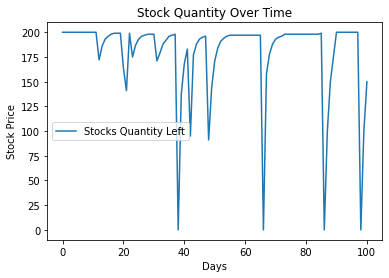

In [22]:
# Print Stock Quantity Over Time
stocks_left = [log["0"]["endogenous"]["StocksLeft"] for log in dense_logs[0]['states']]
plt.plot(np.arange(0,num_days),stocks_left, label="Stocks Quantity Left")
plt.title('Stock Quantity Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Price')
#plt.savefig("miners_gree
plt.show()

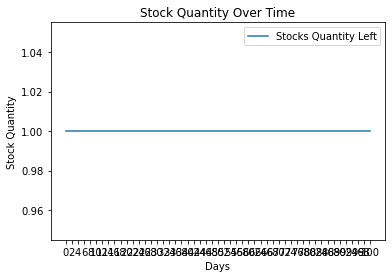

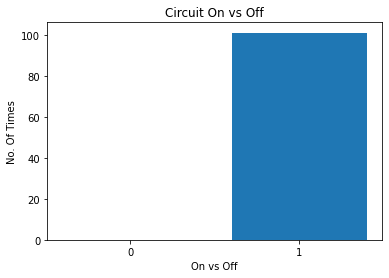

In [23]:
able_to_trade = [log["0"]["endogenous"]["AbleToBuy"] for log in dense_logs[0]['states']]

#Step Plot
plt.step(np.arange(0, num_days), able_to_trade, label="Stocks Quantity Left", where='post')
plt.title('Stock Quantity Over Time')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Stock Quantity')
plt.xticks(ranges)
plt.show()

plt.hist(able_to_trade, bins=[-0.5, 0.5, 1.5], rwidth=0.8)
plt.title('Circuit On vs Off')
plt.xlabel('On vs Off')
plt.ylabel('No. Of Times')
plt.xticks([0, 1])

plt.show()

In [24]:
import matplotlib.pyplot as plt

def plot_policy_decisions(policy_logs, point_size=10):
    planner_logs = [log for log in policy_logs if log['agent_id'] == 'p']
    
    states = [log['state'] for log in planner_logs]
    actions = [log['action'] for log in planner_logs]

    # Assuming states include market liquidity and volatility
    liquidity = [state.get('world-liquidity') for state in states]  # Replace with the correct index or key
    stability = [state.get('world-stability') for state in states]  # Replace with the correct index or key
    
    # Plot decisions
    halt_decisions = [i for i, action in enumerate(actions) if action == 0]  # Assuming action 1 is halt
    continue_decisions = [i for i, action in enumerate(actions) if action == 1]  # Assuming action 0 is continue

    plt.scatter([liquidity[i] for i in halt_decisions], [stability[i] for i in halt_decisions], color='red', label='Halt', s=point_size)
    plt.scatter([liquidity[i] for i in continue_decisions], [stability[i] for i in continue_decisions], color='green', label='Continue', s=point_size)

    plt.xlabel('Market Liquidity')
    plt.ylabel('Market Votality')
    #plt.legend()
    plt.show()
    
def compute_average_metrics(policy_logs):
    planner_logs = [log for log in policy_logs if log['agent_id'] == 'p']
    
    # Extract states
    states = [log['state'] for log in planner_logs]

    # Extract metrics
    stability = [state.get('world-stability') for state in states]
    liquidity = [state.get('world-liquidity') for state in states]
    
    # Compute averages
    average_stability = sum(stability) / len(stability) if stability else 0
    average_liquidity = sum(liquidity) / len(liquidity) if liquidity else 0
    
    return {
        'average_stability': average_stability,
        'average_liquidity': average_liquidity
    }

In [25]:
# Compute policy logs
_, policy_logs_many = generate_rollout_with_policy_logging(trainer, env_obj, num_dense_logs=1)

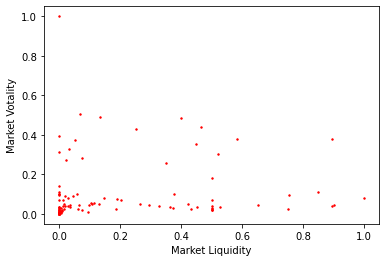

In [26]:
# Plot the policy decisions
plot_policy_decisions(policy_logs_many, 2)

In [27]:
_, policy_logs_many = generate_rollout_with_policy_logging(trainer, env_obj, num_dense_logs=25)
averages = compute_average_metrics(policy_logs_many)
print(averages)

{'average_stability': array([0.11269076]), 'average_liquidity': array([0.20721402])}


In [28]:
# Shutdown Ray after use
#ray.shutdown()